# HDDM-NN TUTORIAL

Welcome to the HDMM_NN Tutorial! For an overview of what HDDM is about, as well as installation instructions, 
visit the github page of this tutorial.

# SECTION 0.0: COLAB PREP

### INSTALLATION COLAB: 1 MOUNT YOUR GOOGLE DRIVE


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

### INSTALLATION COLAB: 2 SWITCH TO TUTORIAL FOLDER

In [ ]:
%cd gdrive/'My Drive'/hddmnn_tutorial

### INSTALLATION COLAB: 3 INSTALL SUPPORT LIBRARIES

In [ ]:
!pip uninstall tensorflow  # tf 2.3.0 is loaded by default --> very slow on our networks
!pip install tensorflow-gpu==1.15 # tf 1.15 ~ 4 times faster (feel free to test this out)
!pip install pymc
!pip install kabuki

### INSTALLATION COLAB: 4 INSTALL HDDM

In [ ]:
!pip install -U --no-deps git+https://github.com/alexanderfengler/hddm@nn_likelihood

# SECTION 0.1: IMPORTS (ANY SETUP)

In [1]:
# MODULE IMPORTS ----

# 
import hddm

# Make simulators visible
import sys
sys.path.append('simulators')

# Data management
import pandas as pd
import numpy as np
import pickle

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Stats functionality
from statsmodels.distributions.empirical_distribution import ECDF

# CUSTOM IMPORTS (LOCAL FILES) --------
import cddm_data_simulation as cds
import boundary_functions as bf

from helper_functions import simulator
from helper_functions import simulator_covariate
from helper_functions import simulator_stimcoding
from helper_functions import model_plot
from helper_functions import caterpillar_plot
from helper_functions import posterior_pair_plot
from helper_functions import simulator_condition_effects
from helper_functions import make_parameter_sets
from helper_functions import _make_trace_plotready_condition
from helper_functions import hddm_preprocess
from helper_functions import simulator_hierarchical
from helper_functions import posterior_predictive_plot
from helper_functions import hddm_include_config
# --------------------------------------

/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# SECTION 1: MODEL INFO / SIMULATION / BASIC PLOTTING

The main concern of this notebook is to present the extended capabilities of the HDDM toolbox as a result of the new `HDDMnn` classes.

Primarily we are interested in the additional models we can now be fit to data. So let's take stock of the models that were added to standard **HDDM**.

### ANGLE

A model with a linearly collapsing angle. Adds a parameter $\theta$, which specifies the angle of the bound.

### WEIBULL

A model that includes a collapsing bound parameterized as the scaled *cdf* of a Weibull distribution.
This adds two parameters to the standard **DDM**, $\alpha$ and $\beta$.

### FAST FULL DDM

This is a faster version of the standard **FULL DDM**. Not a new model per se, but bypassing numerical integration for likelihood evaluations it achieves significant speed-up relatively to the basic **HDDM** version.

### LEVY

The Levy model is essentially a standard **DDM** where noise is not driven by a Gaussian distribution, but the noise process is now parameterized by the new parameter $\alpha$, which interpolates between a Gausian $\alpha = 2$ and a Cauchy (heavy tailed) $\alpha = 1$.

### ORNSTEIN

This model implements the 2-choice **LCA**, which includes a an inhibition / excitation parameter $g$. 

Find more details on these models in our companion paper. 

This section provides you *boiler-plate code* to simulate the respective models, and introduces some of the plots we provide which you may find useful. First, let's define some metadata which you can then change according to the model you want to investigate.

In [3]:
# Metadata
model = 'angle'
n_samples = 2000
includes = hddm_include_config[model]
p_outlier = [] # empty of ['p_outlier']
includes += p_outlier

Let's start by generating some parameters.

In [4]:
# LETS START WITH MAKING SOME PARAMETERS FOR OUR MODEL OF CHOICE
params = make_parameter_sets(model = model,
                                   n_parameter_sets = 5,
                                   param_dict = {'v': [i for i in np.linspace(0.5, 1.5, 5)]})

In [5]:
params

v         a         z         t     theta
0  0.50  0.604492  0.582293  0.808050  0.613123
1  0.75  1.035176  0.512166  1.549074  0.289388
2  1.00  1.730206  0.368748  0.689632  0.801499
3  1.25  0.912814  0.424383  1.232108  0.534393
4  1.50  1.256237  0.584063  1.411147  0.665043

Now let's simulate some data from the model.

In [6]:
simulations = simulator(theta = params.values[0],
                        model = model, 
                        n_samples = n_samples)

Now that we have our simulated data, we look to visualise it.
Let's look at a couple of plots that we can use for this purpose.

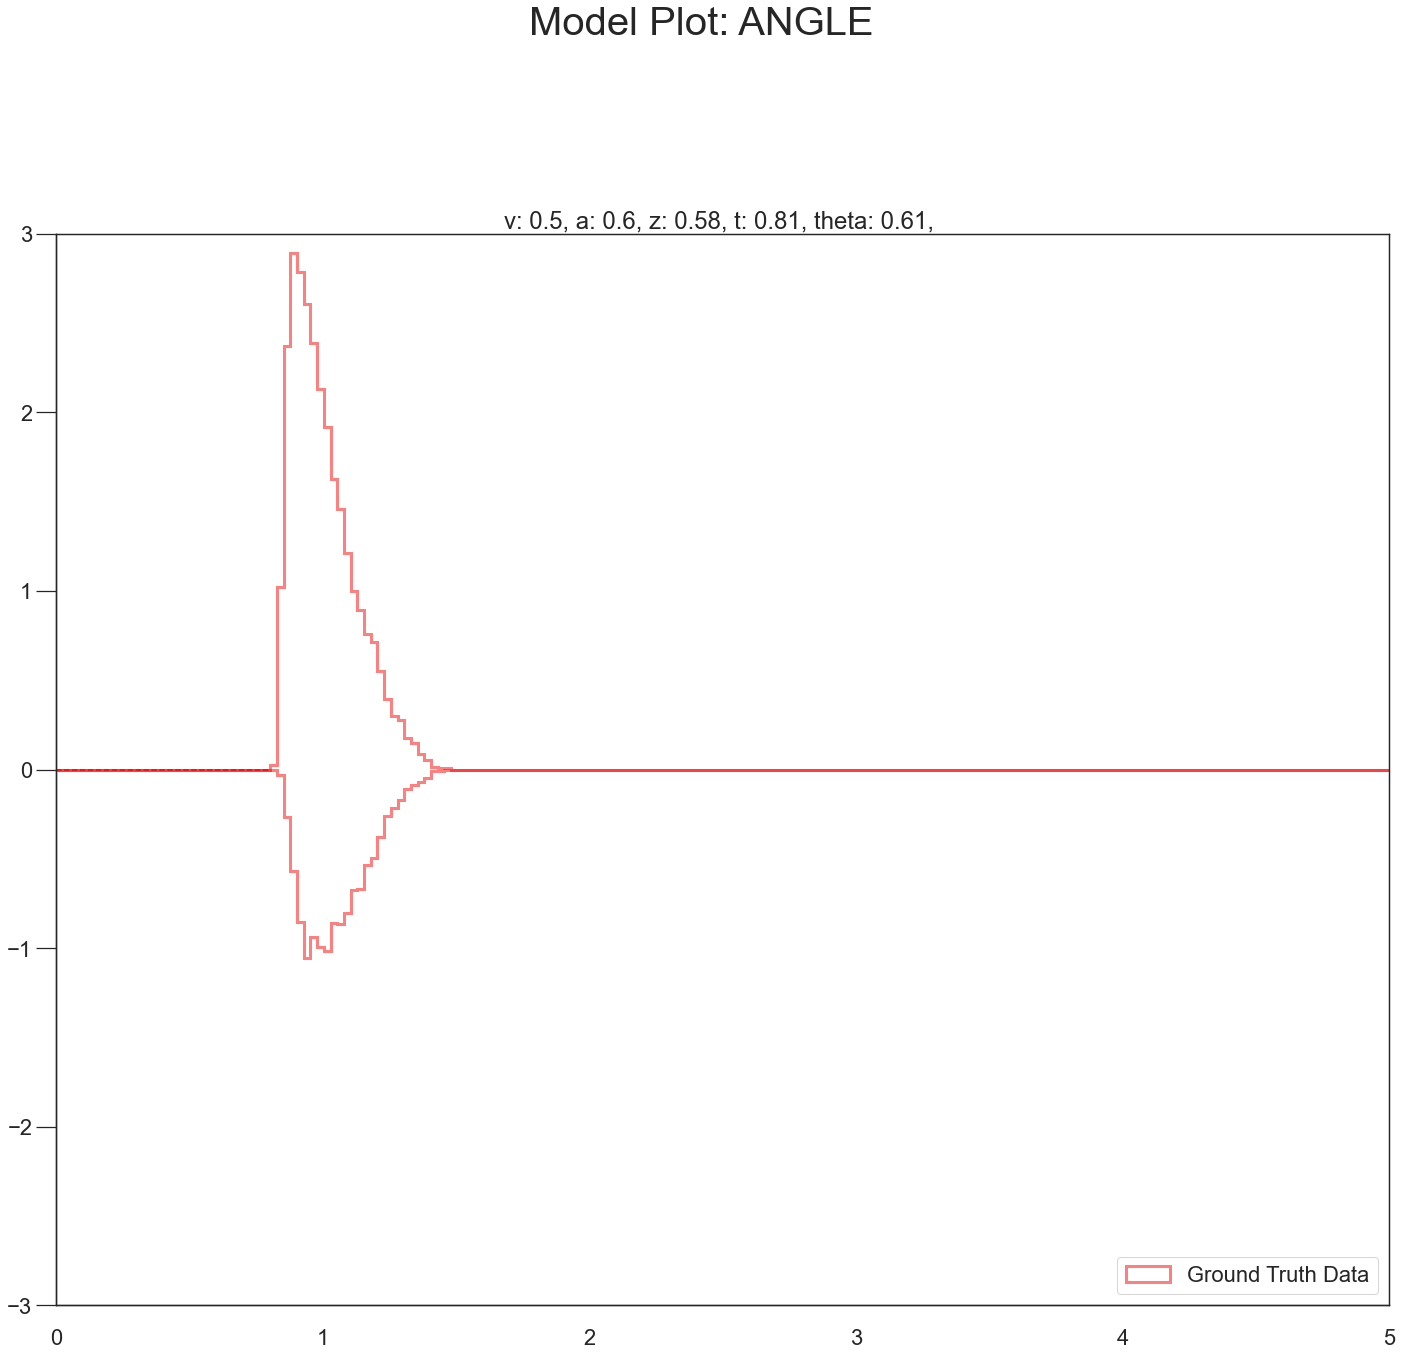

In [7]:
# Model Plots (Only data)
model_plot(ground_truths_parameters = params.values[0],
           posterior_samples = None,
           ground_truths_data = None, #np.concatenate([simulations[0], simulations[1]], axis = 1),
           cols = 1, 
           model_gt = model,
           datatype = 'single_subject',
           n_plots = 1,
           max_t = 5,
           ylimit = 3,
           posterior_linewidth = 3,
           gt_linewidth = 3,
           hist_linewidth = 3,
           bin_size = 0.025,
           show_model = False)

### Varying parameters

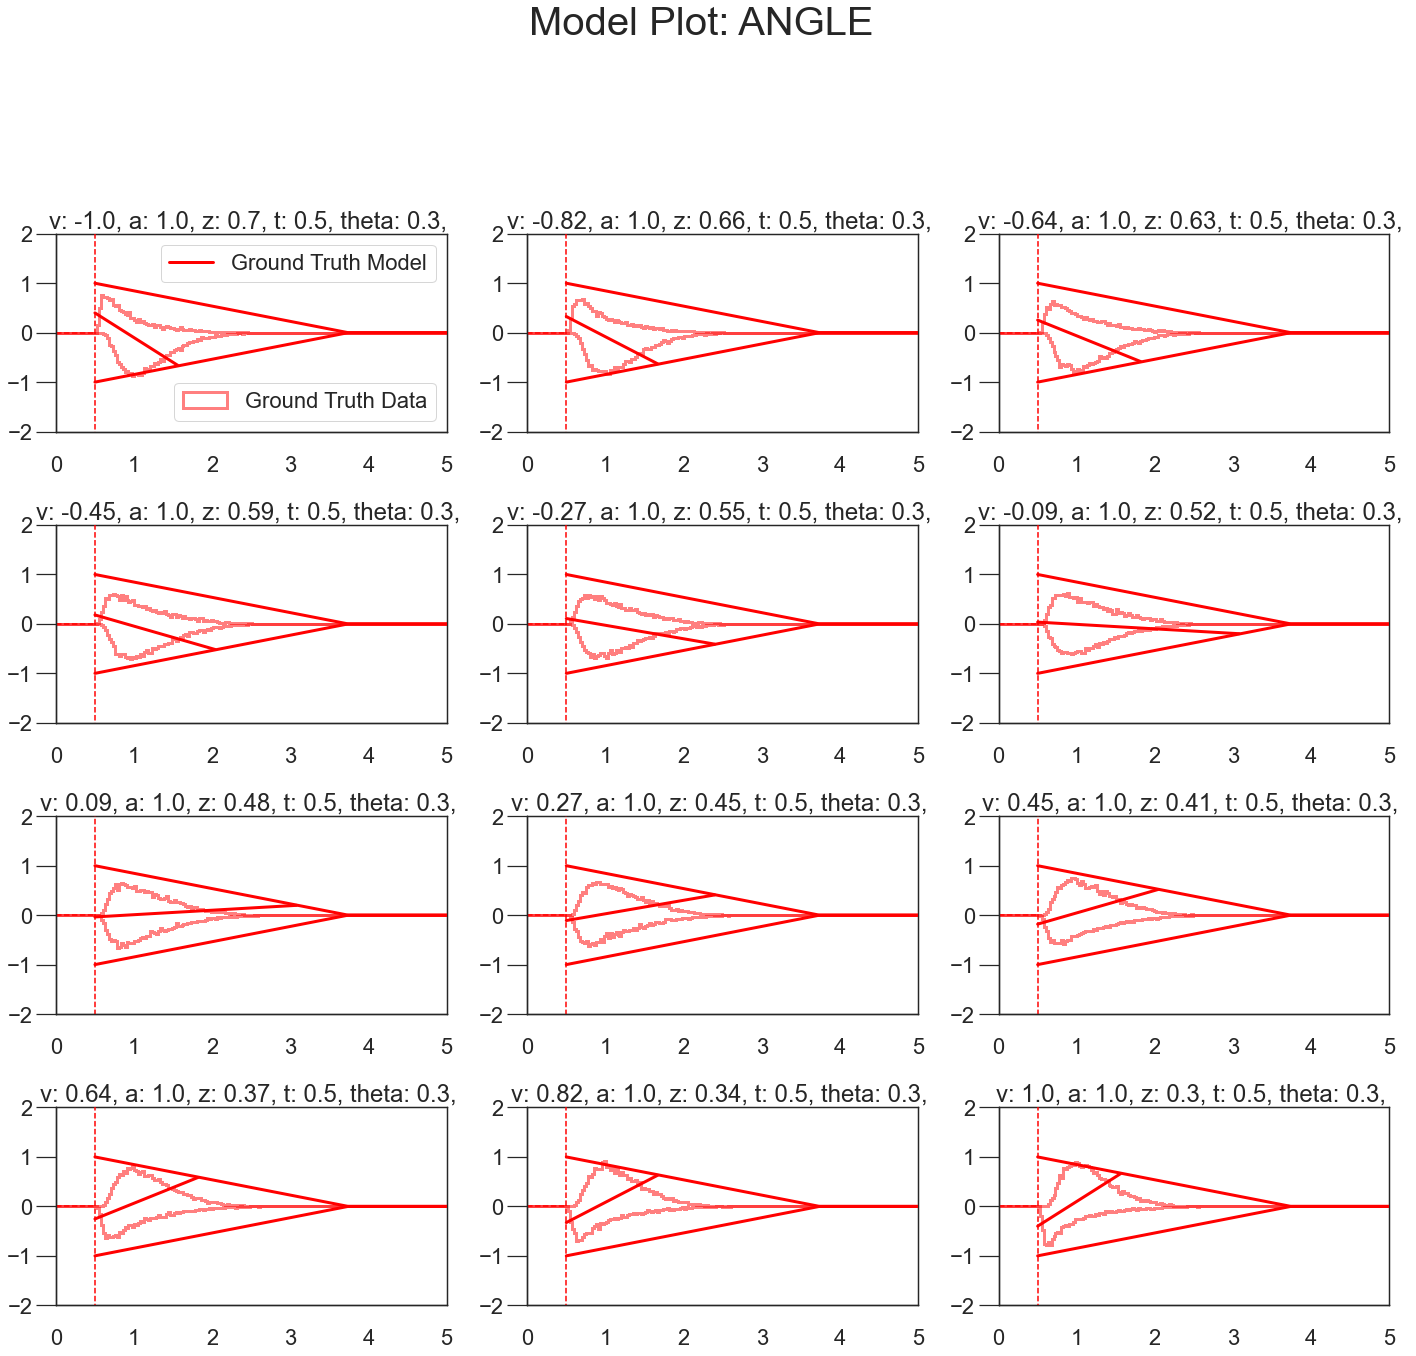

In [16]:
# Plotting the data
n_parameter_sets = 12
show_model = True
params = make_parameter_sets(model = model,
                             n_parameter_sets = n_parameter_sets,
                             param_dict = {'a': [1.],
                                           'v': [i for i in np.linspace(-1, 1, n_parameter_sets)],
                                           'z': [i for i in np.linspace(0.7, 0.3, n_parameter_sets)],
                                           'theta': [0.3], # NOTE THIS IS A MODEL SPECIFIC PARAMETER
                                           't': [0.5]})

# Model Plots (Only data)
model_plot(ground_truths_parameters = params.values,
           cols = 3, 
           model_gt = model,
           n_plots = n_parameter_sets,
           max_t = 5,
           show_model = show_model)

If you are interested, you can use this code to investigate the effects of the other parameters.

# SECTION 2: SINGLE SUBJECT (COLLAPSED) DATA


Now, we try to fit these models to data! Let's start with an simple dataset. In other words, we have one single participant who provides  $n$ datatpoints (reaction times and choices) from some *two alternative forced choice* task paradigm.

In [8]:
# Metadata
nmcmc = 500
model = 'angle'
n_samples = 500
includes = hddm_include_config[model]
p_outlier = [] # empty of ['p_outlier']
includes += p_outlier

In [9]:
# MAKE DATA AND PREPARE FOR HDDM
params = make_parameter_sets(model = model,
                             n_parameter_sets = 1)

simulations = simulator(theta = params.values[0],
                        model = model,
                        n_samples = n_samples)

# Preprocess the data to be ready for HDDM
hddm_data_single_subject = hddm_preprocess(simulations)

In [10]:
# Check parameterization
params

v         a         z         t     theta
0  0.478037  0.609513  0.512674  0.811091  0.325274

In [11]:
# Check dataset
hddm_data_single_subject.head()

rt  response  nn_response subj_idx
0  1.112090         1            1     none
1  1.350087         0           -1     none
2  1.036091         0           -1     none
3  0.952091         0           -1     none
4  1.098091         0           -1     none

In [12]:
# Define the HDDM model
hddm_model = hddm.HDDMnn(hddm_data_single_subject, 
                         model = model,
                         informative = False,
                         include = includes,
                         p_outlier = 0.0,
                         is_group_model = False)

Recognized HDDMnn
RT
0.8550908
1.7860818
Response
[-1.  1.]
knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('theta_bottom', theta)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('z', z), ('p_outlier', 0.0), ('w_outlier', 0.1), ('theta', theta)])
0.0


In [13]:
# Sample
hddm_model.sample(nmcmc, 
                  burn = 100)

 [-----------------100%-----------------] 500 of 500 complete in 19.6 sec

### VISUALIZATION

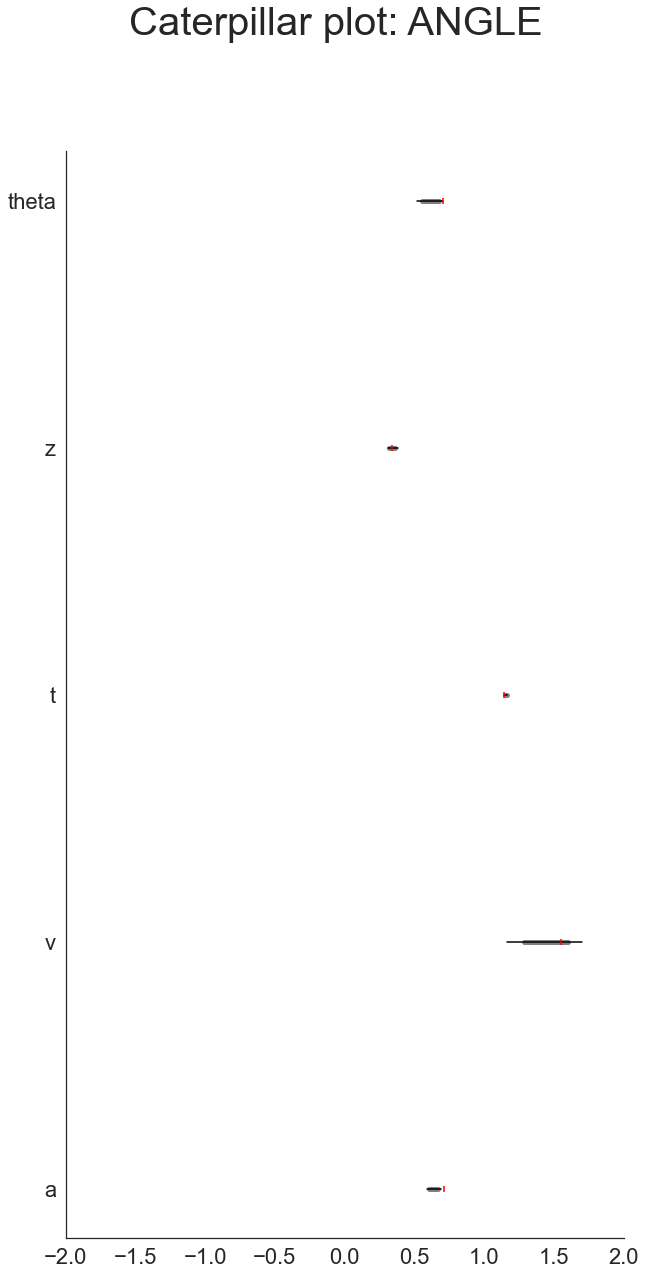

In [31]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model.get_traces(),
                 ground_truths = params.values[0],
                 model = model,
                 datatype = 'single_subject',
                 drop_sd = True)

### Posterior Predictive
Another way to examine whether or not our recovery was satisfactory is to perform posterior predictive checks. Essentially, we are looking to simulate datasets from the trace and check whether it aligns with the ground truth participant data. This answers the question of whether or not these parameters that you recovered can actually reproduce the data. Note that the parameter ``n_post_params`` controls the number of samples drawn from the trace. Here we draw randomly 200 (out of 1200).

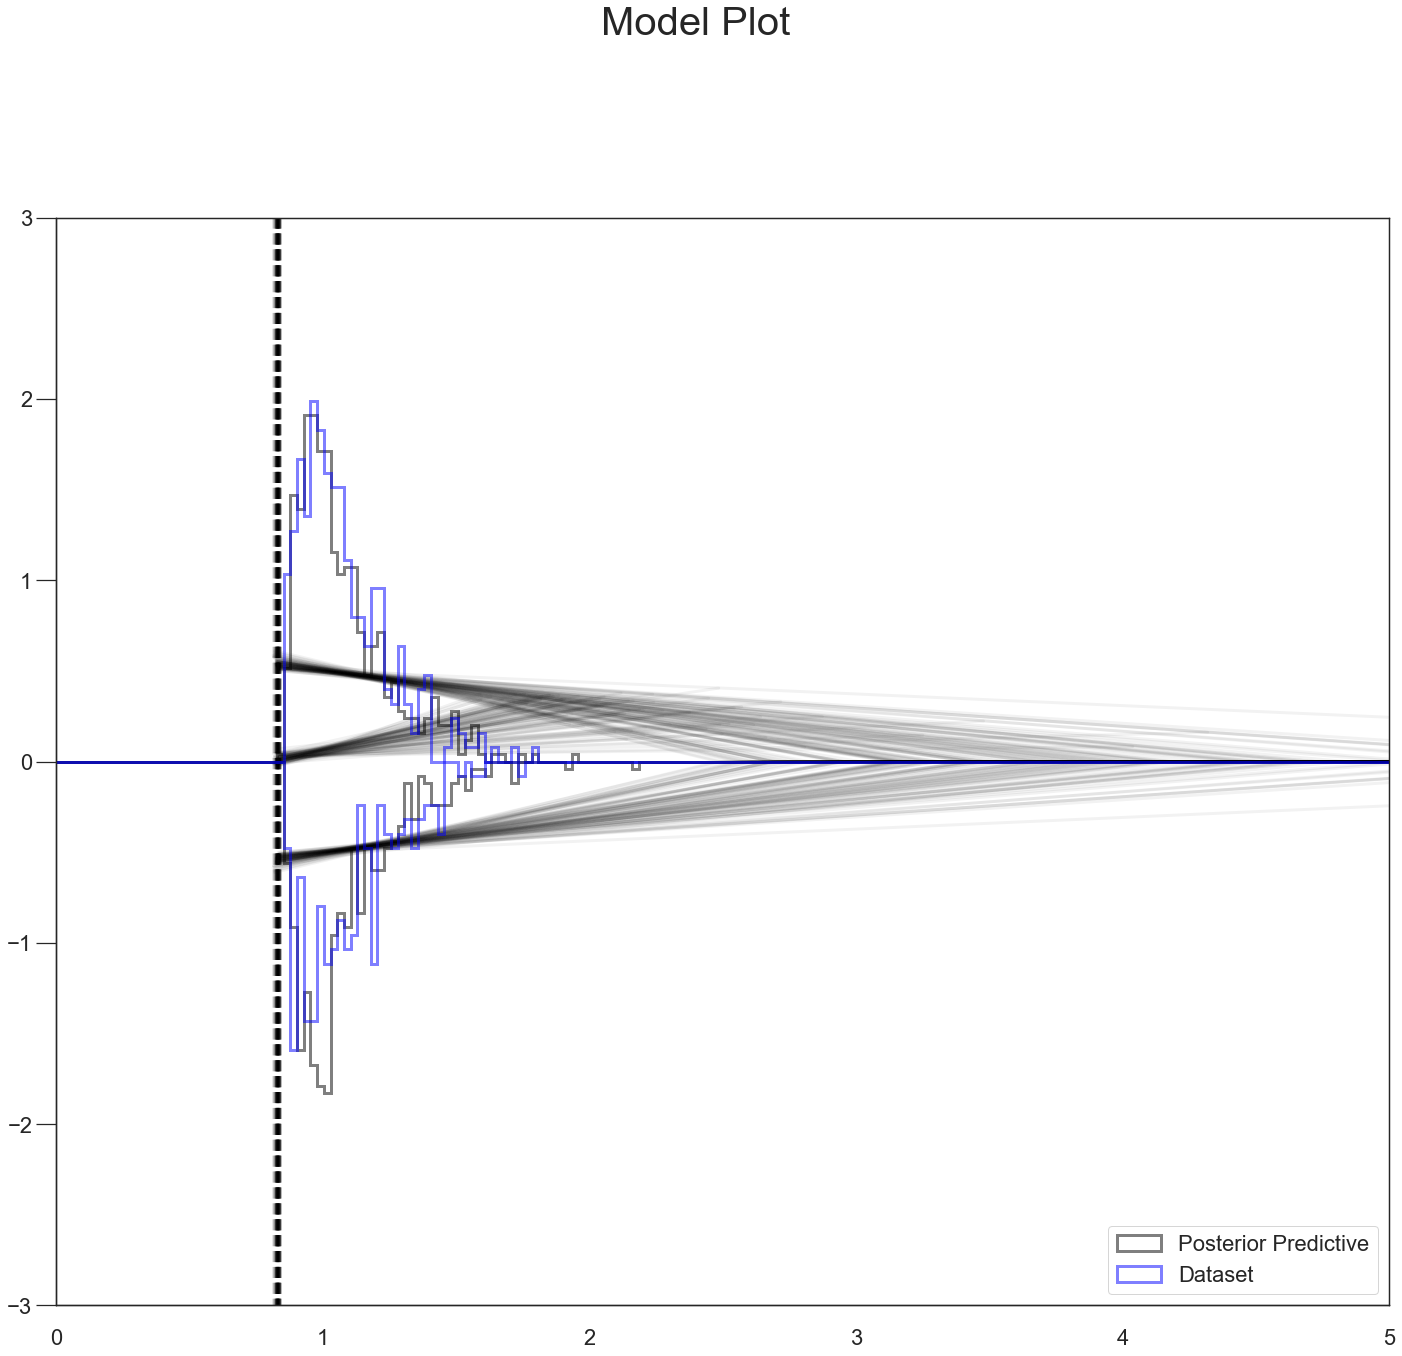

In [16]:
# Posterior Predictive: Do we generate meaningful data from the Posterior Model?
model_plot(ground_truths_parameters = None,
           ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1),
           posterior_samples = hddm_model.get_traces(),
           model_gt = None,
           model_fitted = model,
           n_post_params = 100,
           cols = 1,
           n_plots = 1,
           max_t = 5, 
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject',
           ylimit = 3,
           posterior_linewidth = 3,
           gt_linewidth = 3,
           hist_linewidth = 3,)

/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/afengler/opt/miniconda3/envs/hddm_dev/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


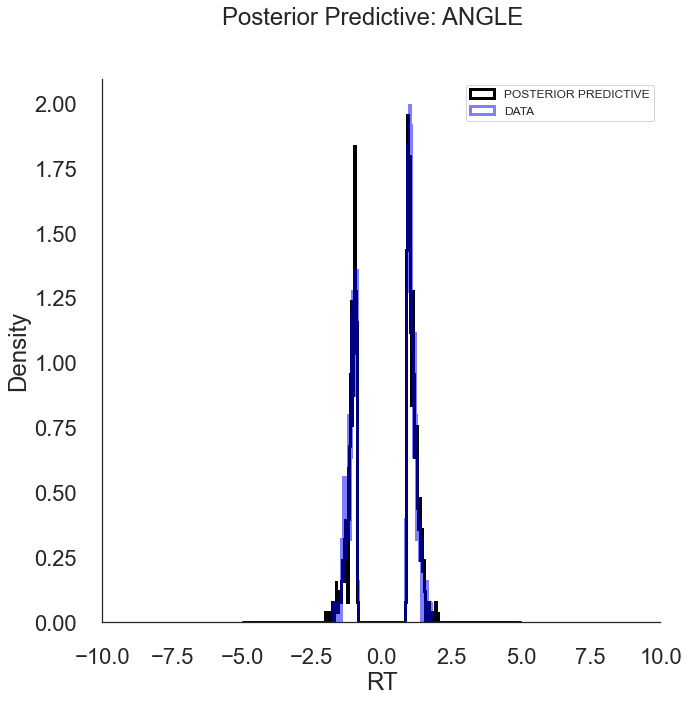

In [19]:
# Posterior Predictive: Do we generate meaningful data from the Posterior Model?
posterior_predictive_plot(ground_truths_parameters = params.values[0],
           ground_truths_data = np.concatenate([simulations[0], simulations[1]], axis = 1),
           posterior_samples = hddm_model.get_traces(),
           model_gt = None,
           model_fitted = model,
           n_post_params = 100,
           n_plots = 1,
           max_t = 5, 
           input_hddm_trace = True,
           datatype = 'single_subject',
           hist_linewidth = 3)

#### A small note on convergence

Note that the MCMC algorithm requires the chain to converge. There are many heuristics that help you identifying problems with convergence, such as the trace plot, auto correltion plot, and marginal posterior histogram. In the trace plots, there might be a problem if you see large jumps. In the autocorrelation plot, there might be a problem if it does not drop rapidly.

Plotting a
Plotting v
Plotting t
Plotting z
Plotting theta


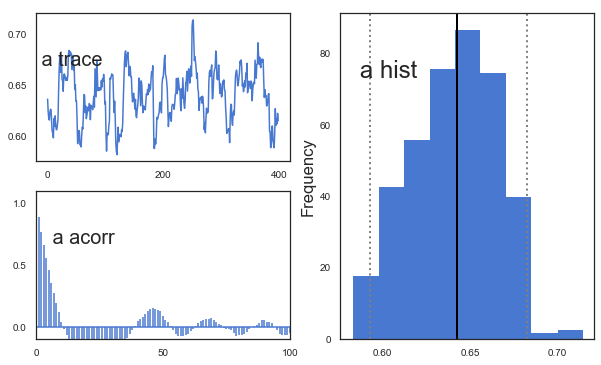

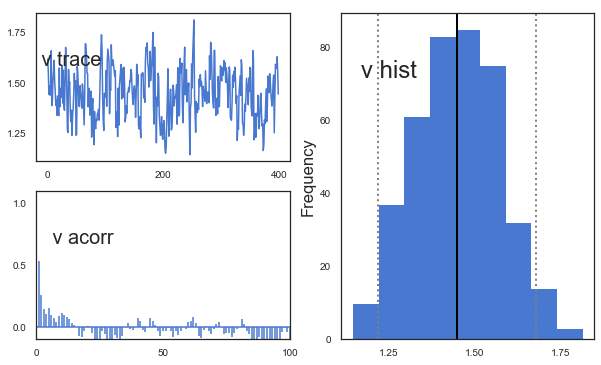

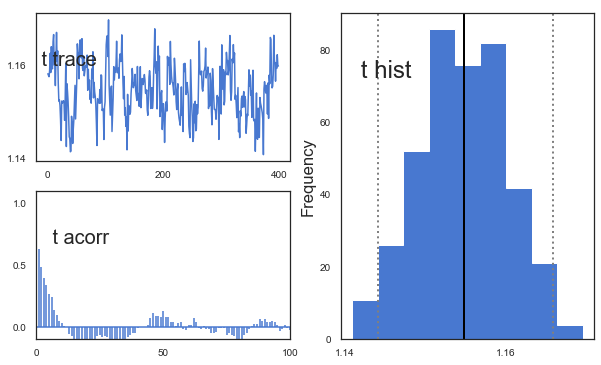

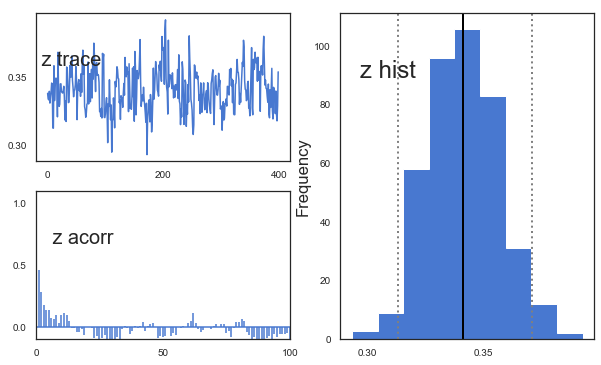

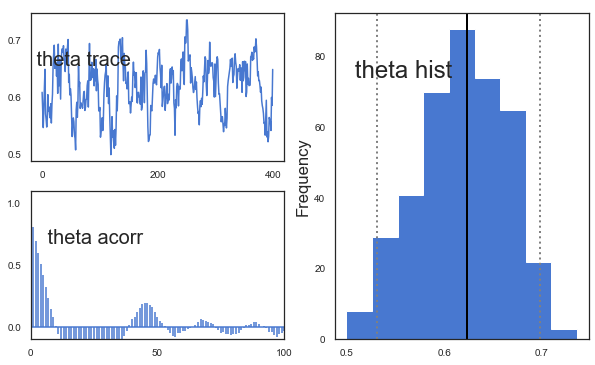

In [35]:
# TAKING A LOOK AT THE POSTERIOR TRACES
hddm_model_single_subject.plot_posteriors(['a', 't', 'v', 'z', 'theta'])

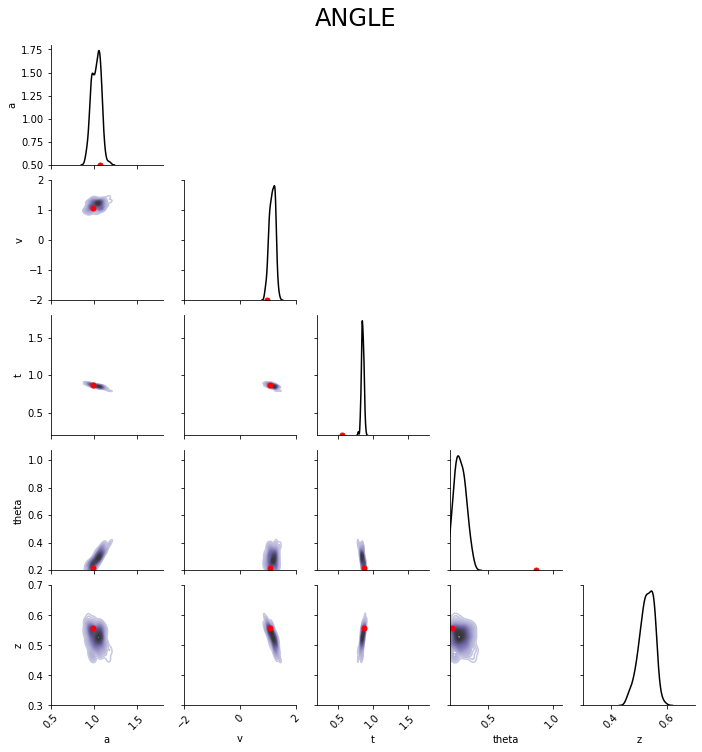

In [10]:
# Pairwise posterior plot
posterior_pair_plot(posterior_samples = hddm_model.get_traces(),
                    height = 10,
                    aspect = 1,
                    n_subsample = 200,
                    ground_truths = params.values[0],
                    model = model)

In [13]:
hddm_model.gen_stats()

mean        std      2.5q       25q       50q       75q     97.5q  \
a        1.0294  0.0527197   0.93881  0.988086   1.02896    1.0694   1.12931   
v       1.15964   0.101028   0.96933   1.08761   1.16006   1.23668   1.35366   
t       0.85648  0.0188871  0.820278  0.845079  0.857037  0.869895  0.891777   
z      0.528634   0.025416    0.4751  0.509546  0.530362  0.548453  0.573562   
theta  0.278943  0.0479883  0.189506  0.245137  0.279523  0.311806  0.364347   

           mc err  
a      0.00488268  
v      0.00815114  
t      0.00173543  
z      0.00222707  
theta  0.00411922

Ideally we would want to simulate a dataset from scratch and fitting it. The code to do so, is commented out above. However, due to time constraints, we will sometimes load in a dataset, its ground truth parameter and its trace. Note that the ``pickle`` is a tuple of:

0. The trace
1. Ground truth parameter
2. Dataset

# SECTION 3: HIERARCHICAL MODELS

The 'h' in `hddm` stands for hierarchical, so let's do it! If we have data from multiple participants and we assume that the parameters of single participants are drawn from respective **group** or **global** distributions, we can model this explicitly in `hddm` by specifying `is_group_model = True`.

Implicitly we are fitting a model of the following kind,

$$p(\{\theta_j\}, \{\theta_g\} | \mathbf{x}) \propto \left[ \prod_j^{J} \left[ \prod_i^{N_j} p(x_i^j | \theta_j) \right] p(\theta_j | \theta_g) \right] p( \theta_g | \theta_h )$$

where (let's say for the **angle model**),
1. $\theta_j = \{v_j, a_j, z_j, t_j, \theta_j \}$, are the model parameters for **subject j**.

2. $\theta_g = \{v_g^{\mu}, a_g^{\mu}, z_g^{\mu}, t_g^{\mu}, \theta_g^{\mu}, v_g^{\sigma}, a_g^{\sigma}, z_g^{\sigma}, t_g^{\sigma}, \theta_g^{\sigma} \}$ (scary, but for completeness), are the **mean** and **variance** parameters for our group level normal distributions, and $\{ \theta_h \}$ are **fixed hyperparameters**.

3. $x_i^j = \{rt_i^j, c_i^j \}$, are the **choice and reaction time**  of **subject j** during **trial i**.

In words, the right hand side of the equation tells us that we have a **global parameter distribution** with certain **means** and **variances** for each parameter (we want to figure these means and variances out), from which the **subject level parameters** are drawn and finally **subject level datapoints** follow the likelihood distribution of our **ddm / angle / weibull / you name it** mdoels.

In [2]:
# Metadata
nmcmc = 300
model = 'angle'
n_samples_by_subject = 500
n_subjects = 5
includes = hddm_include_config[model]
p_outlier = [] # empty of ['p_outlier']
includes += p_outlier

In [19]:
# Simulate data angle
hddm_data_hierarchical, gt_hierarchical, gt_mat_hierarchical = simulator_hierarchical(n_subjects = n_subjects,
                                                                                      model = model,
                                                                                      n_samples_by_subject = n_samples_by_subject)

In [22]:
hddm_model = hddm.HDDMnn(hddm_data_hierarchical, 
                         model = model,
                         informative = False,
                         include = includes,
                         is_group_model = True,
                         p_outlier = 0.0)

Recognized HDDMnn
RT
0.3266703
1.9365625
Response
[-1.  1.]
knodes
OrderedDict([('a', a), ('a_std', a_std), ('a_tau', a_tau), ('a_bottom', a_subj), ('v', v), ('v_std', v_std), ('v_tau', v_tau), ('v_bottom', v_subj), ('t', t), ('t_std', t_std), ('t_tau', t_tau), ('t_bottom', t_subj), ('z_trans', z_trans), ('z', z), ('z_std', z_std), ('z_tau', z_tau), ('z_subj_trans', z_subj_trans), ('z_bottom', z_subj), ('theta', theta), ('theta_std', theta_std), ('theta_tau', theta_tau), ('theta_bottom', theta_subj)])
wfpt parents: 
OrderedDict([('a', a_subj), ('v', v_subj), ('t', t_subj), ('z', z_subj), ('p_outlier', 0.0), ('w_outlier', 0.1), ('theta', theta_subj)])
0.0


In [24]:
# # Sampling:
hddm_model.sample(nmcmc,
                  burn = 100)

 [-----------------100%-----------------] 300 of 300 complete in 51.5 sec

In [26]:
# Sample
hddm_model.get_traces()

a     a_std  a_subj.000  a_subj.001  a_subj.002  a_subj.003  \
0    1.139640  0.076142    1.252118    1.059380    1.105617    1.157818   
1    1.120866  0.101471    1.248854    1.096210    1.106599    1.169002   
2    1.119932  0.110955    1.230561    1.086055    1.144362    1.168719   
3    1.147737  0.074107    1.234630    1.093487    1.147866    1.153451   
4    1.095031  0.084571    1.208943    1.069257    1.150376    1.156450   
..        ...       ...         ...         ...         ...         ...   
195  1.053004  0.086167    1.123109    1.000239    1.089227    1.082535   
196  1.048740  0.158818    1.115509    0.988854    1.058605    1.067120   
197  1.038099  0.119421    1.111999    0.996118    1.060081    1.092733   
198  1.067243  0.119756    1.195147    0.995079    1.060116    1.080016   
199  0.999087  0.107013    1.188130    0.983723    1.065607    1.081291   

     a_subj.004         v     v_std  v_subj.000  ...  z_subj_trans.002  \
0      1.013896  1.347474  0.072847    1.463427  ...         -0.102373   
1      1.011198  1.386456  0.118094    1.310375  ...          0.014245   
2      0.998503  1.191264  0.125080    1.429353  ...         -0.003619   
3      0.979974  1.329884  0.306993    1.334551  ...          0.025044   
4      0.984872  1.301930  0.391984    1.280963  ...          0.013195   
..          ...       ...       ...         ...  ...               ...   
195    0.993911  1.313997  0.090345    1.384746  ...         -0.005270   
196    0.996188  1.317238  0.082140    1.379127  ...         -0.085376   
197    0.927564  1.296665  0.114365    1.477544  ...         -0.090951   
198    0.919797  1.400524  0.283622    1.382117  ...          0.004635   
199    0.901077  1.147505  0.625401    1.500864  ...         -0.024587   

     z_subj_trans.003  z_subj_trans.004     theta  theta_std  theta_subj.000  \
0           -0.037159         -0.066363  0.426597   0.137269        0.482107   
1           -0.081819         -0.005273  0.442807   0.019877        0.499056   
2           -0.081232          0.060968  0.481166   0.022846        0.493536   
3           -0.070061          0.045977  0.475087   0.011013        0.484932   
4           -0.126928         -0.026525  0.493115   0.007940        0.485665   
..                ...               ...       ...        ...             ...   
195         -0.173221          0.117544  0.396499   0.021429        0.391472   
196         -0.176691          0.062622  0.404190   0.015351        0.430142   
197         -0.048362          0.102968  0.400061   0.014377        0.426483   
198          0.101010          0.095764  0.416642   0.010897        0.413605   
199          0.086174          0.056367  0.401935   0.012251        0.401643   

     theta_subj.001  theta_subj.002  theta_subj.003  theta_subj.004  
0          0.488485        0.424925        0.509763        0.476079  
1          0.495804        0.442012        0.475413        0.477757  
2          0.509465        0.494849        0.489790        0.486723  
3          0.472701        0.495370        0.491150        0.484252  
4          0.491345        0.495128        0.495560        0.492241  
..              ...             ...             ...             ...  
195        0.436071        0.411364        0.393743        0.427672  
196        0.361866        0.389294        0.433263        0.416832  
197        0.403313        0.401214        0.406438        0.411358  
198        0.400633        0.391063        0.410637        0.422937  
199        0.401948        0.393397        0.411086        0.417501  

[200 rows x 35 columns]

/Users/afengler/OneDrive/git_repos/hddmnn_tutorial/helper_functions.py:1527: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  frameon = False)


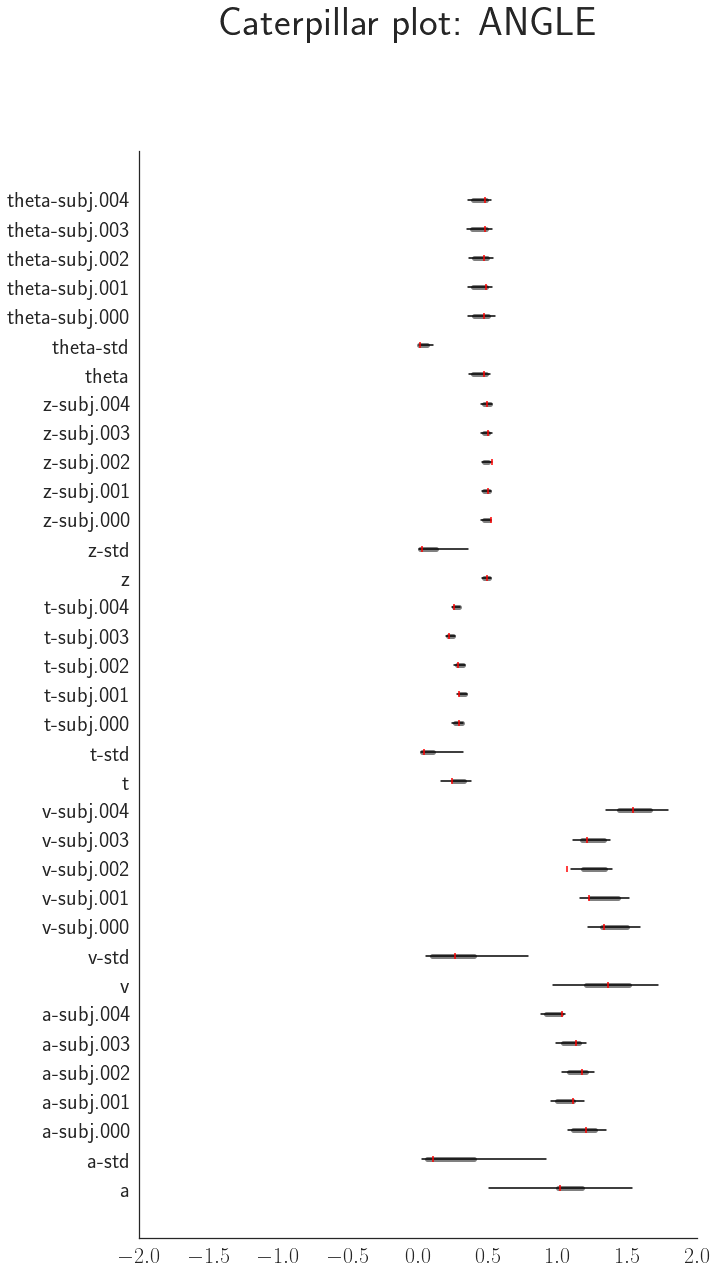

In [27]:
# Caterpillar Plot
caterpillar_plot(posterior_samples = hddm_model.get_traces(),
                 ground_truths = gt_hierarchical,
                 model = model,
                 datatype = 'hierarchical',
                 x_lims = [-2, 2],
                 aspect_ratio = 2,
                 drop_sd = False,
                 save = False)

(5, 200, 5)


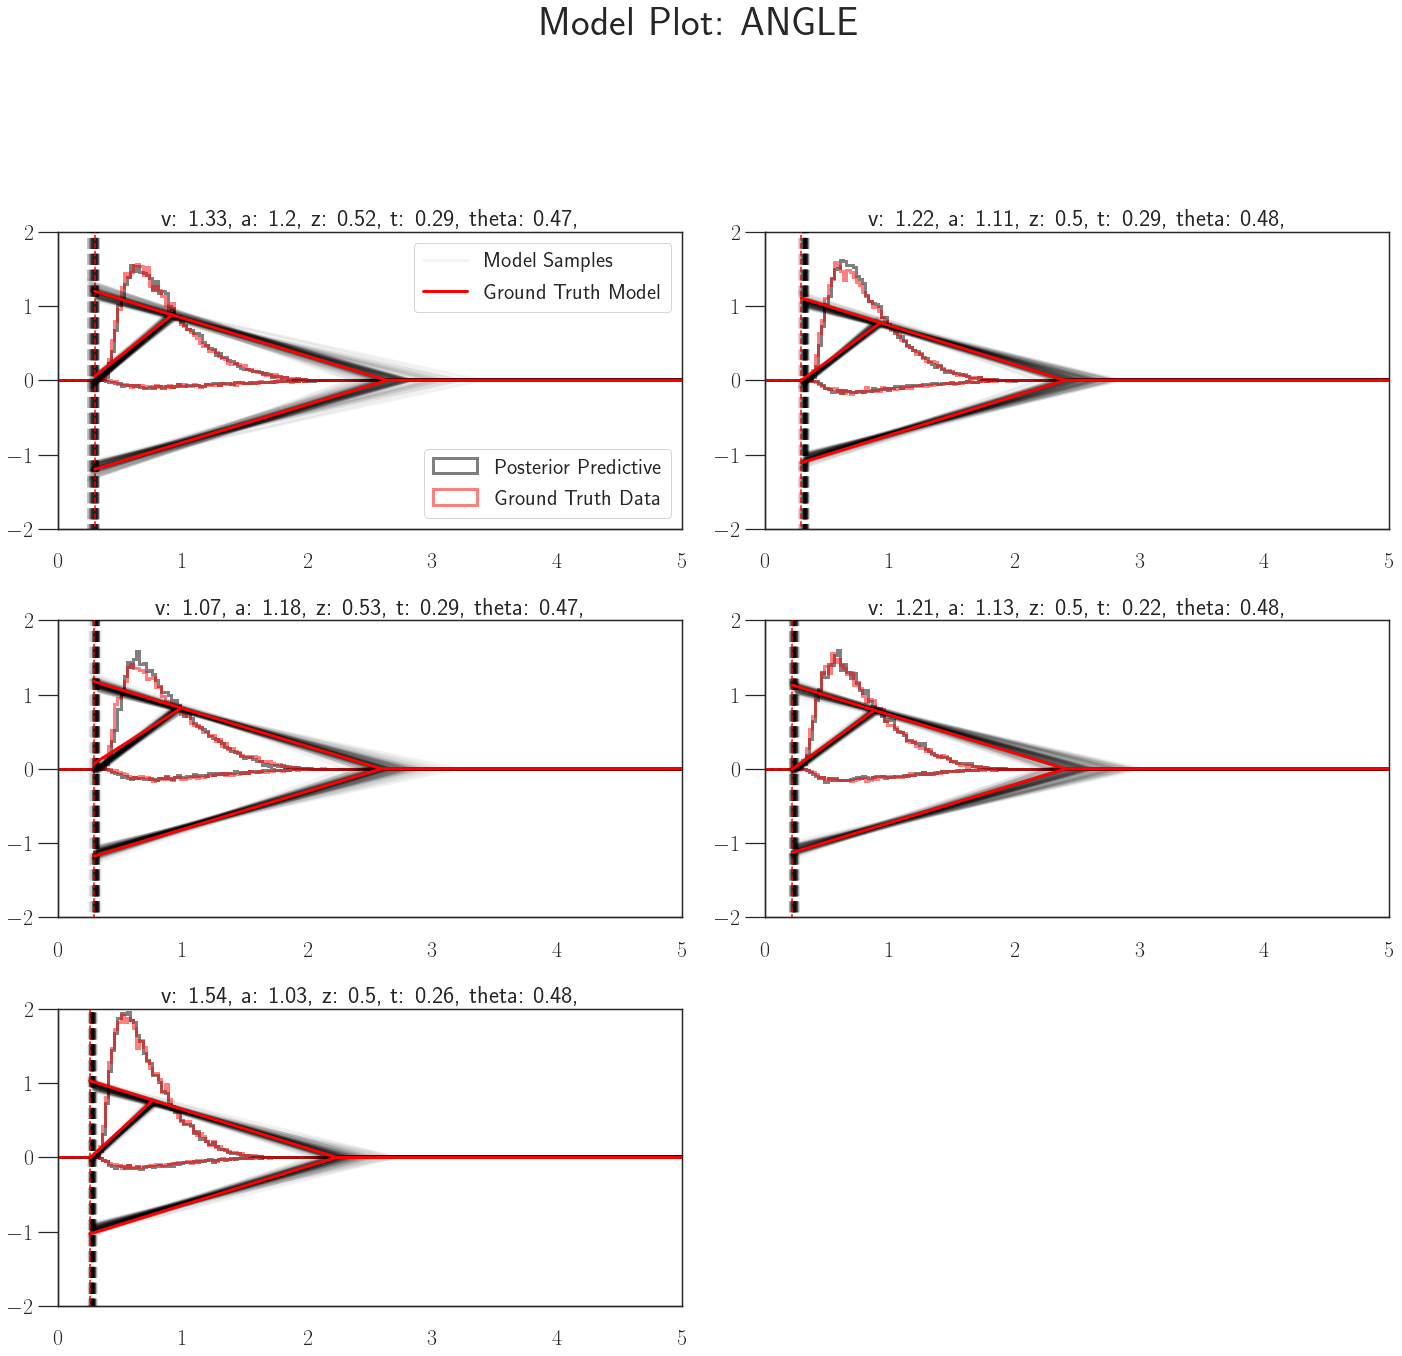

In [29]:
# Posterior Predictive
model_plot(ground_truths_parameters = gt_mat_hierarchical,
           posterior_samples = hddm_model.get_traces(),
           ground_truths_data = None,
           input_hddm_trace = True,
           n_post_params = 100,
           samples_by_param = 200,
           cols = 2,
           model_gt = model,
           model_fitted = model,
           datatype = 'hierarchical',
           n_plots = 10,
           max_t = 5,
           show_model = True,
           save = False)

# SECTION 4: PARAMETER VARIES BY CONDITION

An important aspect of these posterior analysis, is the consideration of experiment design.
We may have an experiment in which subject are exposed to a variety of conditions, 
such as for example different degrees of difficulty of the same task

It is often reasonable to assume that all but the conceptually relevant parameters are common across conditions.

As a by-product, such experiment designs can help us with the recovery of the constant parameters, by probing those static aspects of the model across varying kinds of datasets (driven by targeted manipulation of variable aspects of the model).

Implicitly we fit the following kind of model,

$$p( \{\theta_c \}, \theta | \mathbf{x} ) \propto  \left[ \prod_c^C  \left[ \prod_i^{N_i} p( x_i^c | \theta_c, \theta ) \right] p(\theta_c)  \right] p(\theta)$$


Where $\theta_c$ is the condition dependent part of the parameter space, and $\theta$ forms the portion of parameters which remain constant across condtions. 

To give a more concrete example involving the **weibull model** (executed below), consider a dataset for a single participant, who went through four conditions of an experiment. Think of the conditions as manipulating the payoff structure of the experiment to incentivize / disincentivize accuracy in favor of speed. We operationalize this by treating the $a$ parameter, the initial boundary separation, as affected by the manipulation, while the rest of the parameters are constant across all experiment conditions.

The resulting model would be of the form, 

$$ p( {a_c}, v, z, t, \alpha, \beta | x ) \propto \left[ \prod_c^C  \left[ \prod_i^{N_c} p( x_i^c | a_c, v, z, t, \alpha, \beta)  \right] p(a_c) \right]  p(v, z, t, \alpha, \beta)$$ 

In [28]:
# Metadata
nmcmc = 1000
model = 'weibull_cdf'
n_samples_by_condition = 500
n_conditions = 5
includes = hddm_include_config[model]
p_outlier = [] # empty of ['p_outlier']
includes += p_outlier

In [29]:
# Generating some data
# We generate data such that only one parameter varies by condition (in this case 'a' --> the initial boundary separation)
hddm_data_condition, gt_condition, gt_mat_condition = simulator_condition_effects(n_conditions = n_conditions, 
                                                                                  n_samples_by_condition = n_samples_by_condition,
                                                                                  condition_effect_on_param = ['a'], 
                                                                                  model = model,
                                                                                  )

In [30]:
hddm_data_condition.head()

rt  response  nn_response  condition
0  1.389608         0           -1          0
1  3.022645         1            1          0
2  2.630631         1            1          0
3  3.695596         1            1          0
4  1.329609         0           -1          0

In [31]:
# Ground Truth Parameters
gt_condition

{'a(0)': 1.2643571259057644,
 'a(1)': 0.6689318557246906,
 'a(2)': 0.85947158848022,
 'a(3)': 1.4461587512727083,
 'a(4)': 0.6579088568092615,
 'v': -0.2632894591756698,
 'z': 0.44903559534332216,
 't': 0.9876099626575938,
 'alpha': 3.7845707684518954,
 'beta': 5.765120078287825}

In [32]:
# Make HDDM Model 
hddm_model = hddm.HDDMnn(hddm_data_condition, 
                         model = model,
                         informative = False,
                         include = includes,
                         p_outlier = 0.0,
                         is_group_model = False, 
                         depends_on = {'a': 'condition'})

Recognized HDDMnn
RT
1.02161
6.8803654
Response
[-1.  1.]
knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('alpha_bottom', alpha), ('beta_bottom', beta)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('z', z), ('p_outlier', 0.0), ('w_outlier', 0.1), ('alpha', alpha), ('beta', beta)])
0.0


In [33]:
# Sample
hddm_model.sample(nmcmc, burn = 100)

 [-----------------100%-----------------] 501 of 500 complete in 151.3 sec

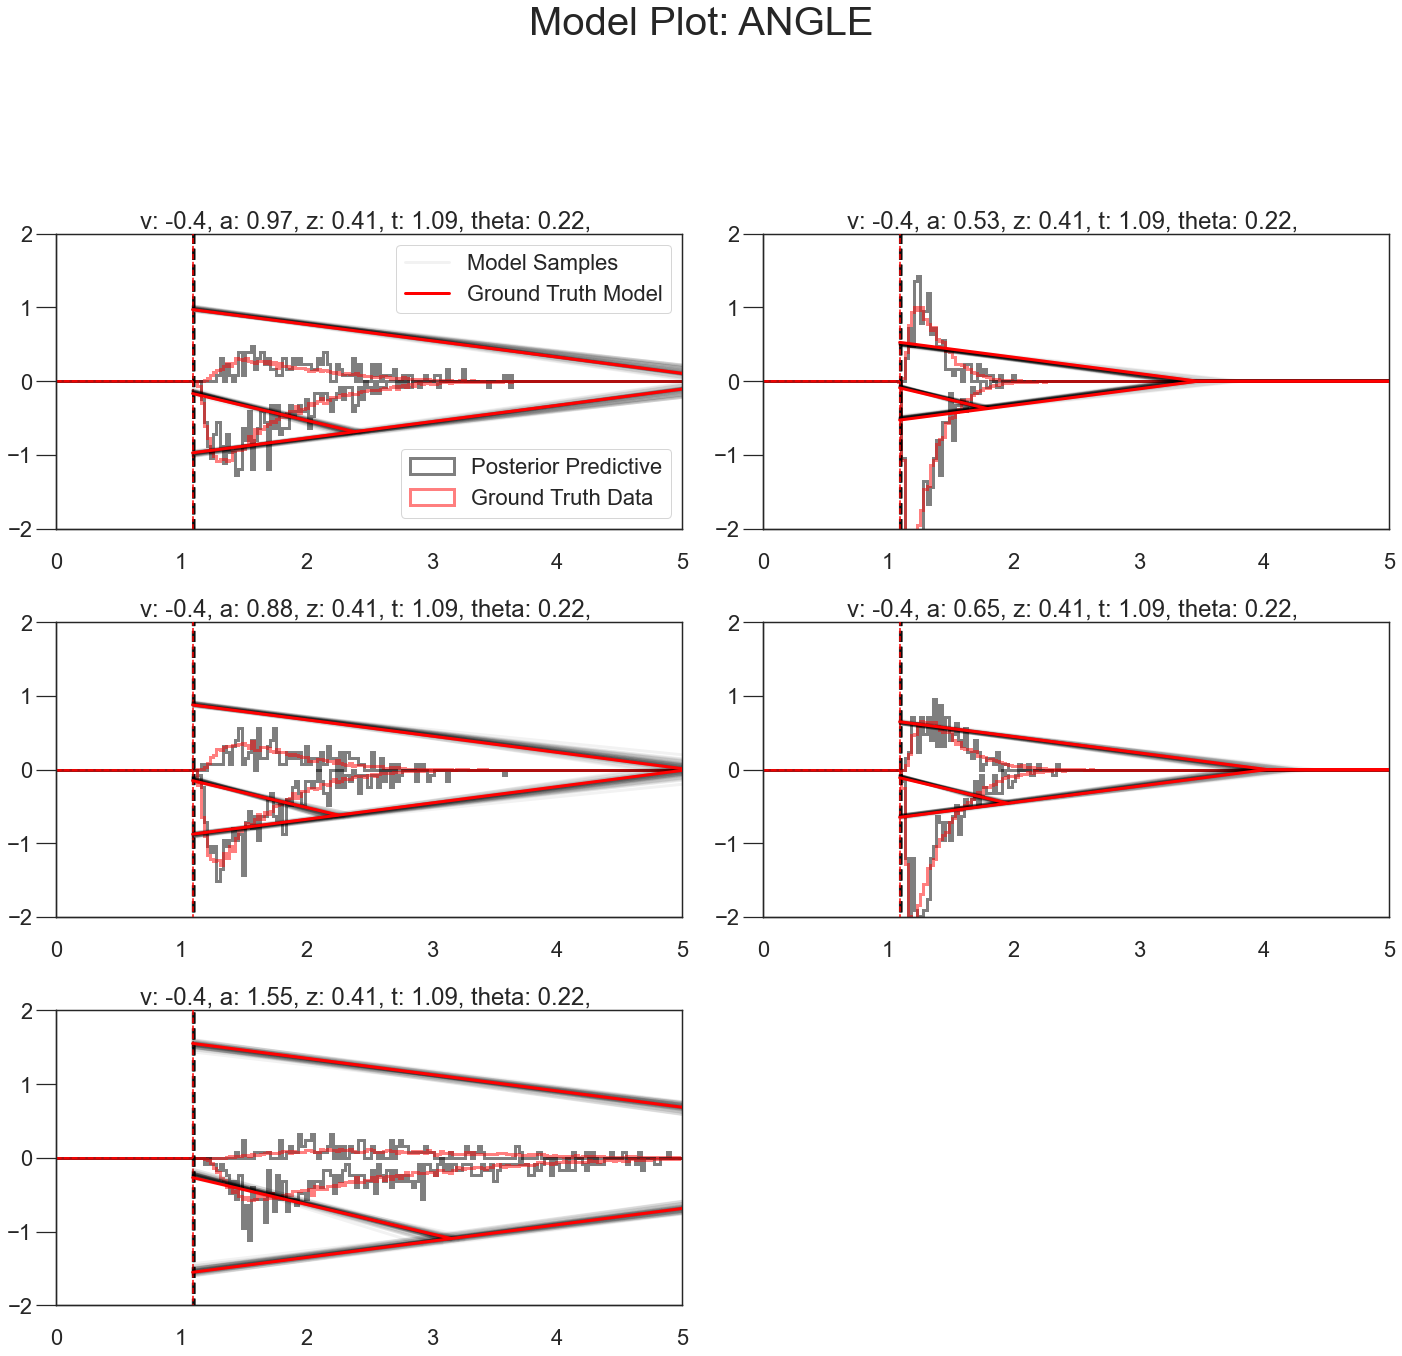

In [9]:
model_plot(posterior_samples = hddm_model.get_traces(),
           ground_truths_parameters = gt_mat_condition,
           ground_truths_data = None,
           model_gt = model,
           model_fitted = model,
           datatype = 'condition',
           input_hddm_trace = True,
           n_post_params = 50,
           n_plots = 4,
           cols = 2,
           show_model = True)

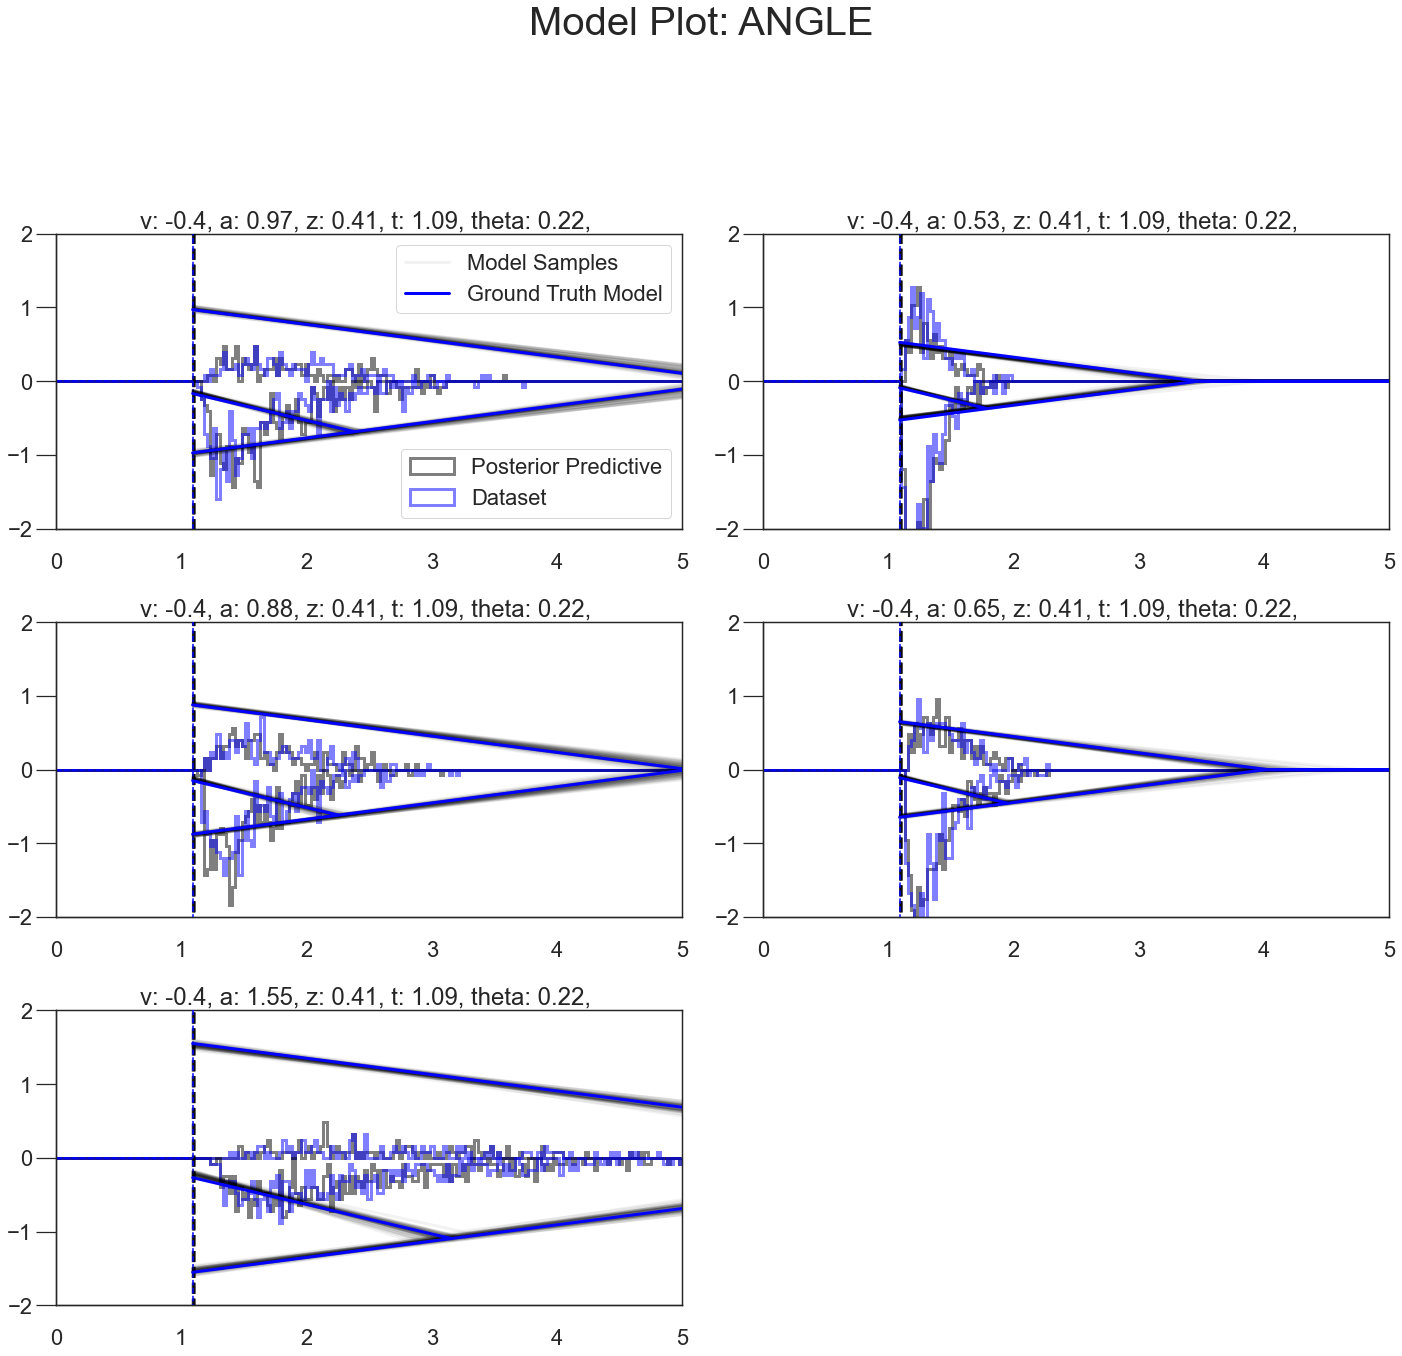

In [10]:
model_plot(posterior_samples = hddm_model.get_traces(),
           ground_truths_parameters = gt_mat_condition,
           ground_truths_data = hddm_data_condition,
           model_gt = model,
           model_fitted = model,
           datatype = 'condition',
           input_hddm_trace = True,
           n_post_params = 50,
           n_plots = 4,
           cols = 2,
           show_model = True)

# SECTION 5: REGRESSORS

This section provides a simple working example using the Neural Networks with the Regression backend.
The regression back-end allows linking parameters to trial-by-trial covariates via a (general) linear model.

In [19]:
# Metadata
nmcmc = 1000
model = 'angle'
n_samples = 1000
includes = hddm_include_config[model]
p_outlier = [] # empty of ['p_outlier']
includes += p_outlier

In [20]:
# Generate some basic simulations
params =  make_parameter_sets(model = model,
                              n_parameter_sets = 1)

simulations = simulator(theta = params.values[0],
                        model = model, 
                        n_samples = n_samples)

hddm_data_single_subject_regress = hddm_preprocess(simulations)

In [21]:
simulations = simulator_covariate(dependent_params = ['v'],
                                  model = model,
                                  n_samples = 1000,
                                  beta = 0.1,
                                  subj_id = 'none')

In [22]:
# Mean parameters
simulations[1].mean(axis = 0)

array([-0.35310502,  1.00420861,  0.66327803,  1.79380506,  0.74344692])

In [23]:
# Set up the regressor a regressor:

v_reg = {'model': 'v ~ 1 + BOLD', 'link_func': lambda x: x}
#a_reg = {'model': 'a ~ 1 + BOLD', 'link_func': lambda x: x}
#t_reg = {'model': 't ~ 1 + BOLD', 'link_func': lambda x: x}
#g_reg = {'model': 'a ~ 1 + BOLD', 'link_func': lambda x: x}

reg_descr = [v_reg] #[v_reg, a_reg, t_reg, g_reg] # theta_reg]

In [24]:
# Make HDDM model
hddm_reg = hddm.HDDMnnRegressor(simulations[0], 
                                reg_descr, 
                                include = set(hddm_include_config[model]),
                                p_outlier = 0.0,
                                model = model)

outcomes:  v
Adding these covariates:
['v_Intercept', 'v_BOLD']
Recognized HDDMnn
RT
1.827805
2.7567961
Response
[-1.  1.]
Printing reg outcome:
{'v'}
{'t', 'z', 'a', 'theta'}
knodes
OrderedDict([('a_bottom', a), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('theta_bottom', theta)])
knodes
OrderedDict([('a_bottom', a), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('theta_bottom', theta)])
reg:  {'outcome': 'v', 'model': ' 1 + BOLD', 'params': ['v_Intercept', 'v_BOLD'], 'link_func': <function <lambda> at 0x145d23170>}
param_lookup passed to _create stochastic_knodes
v
knodes
OrderedDict([('v_bottom', v)])
['v_bottom']
name:  v_bottom
names:  ['v_bottom']
v_reg
wfpt parents: 
OrderedDict([('a', a), ('v', v_reg), ('t', t), ('z', z), ('p_outlier', 0.0), ('w_outlier', 0.1), ('theta', theta)])


In [25]:
# Sample
hddm_reg.sample(1000, burn = 100)

 [-----------------100%-----------------] 1001 of 1000 complete in 95.6 sec

In [26]:
# Posterior Stats
hddm_reg.gen_stats()

mean         std       2.5q       25q       50q       75q  \
a            0.958451   0.0362083   0.883715  0.934113  0.957837  0.982394   
t             1.80434  0.00891897    1.78627   1.79807   1.80463   1.81025   
z            0.674148   0.0128106   0.649253  0.665236  0.674879  0.683249   
theta         0.69769    0.030706   0.627612  0.678875  0.698442  0.718016   
v_Intercept -0.418993   0.0830202  -0.581459 -0.475415 -0.418053  -0.36071   
v_BOLD       0.193984   0.0896016  0.0203723  0.132638  0.194037  0.254637   

                97.5q       mc err  
a             1.03516   0.00336603  
t              1.8217  0.000748276  
z            0.698006  0.000889686  
theta        0.756029   0.00278577  
v_Intercept -0.260719   0.00529264  
v_BOLD       0.366308   0.00284056

# SECTION 6: STIM CODING

In [2]:
# Metadata
nmcmc = 500
model = 'angle'
n_samples_by_condition = 500
split_param = 'z'
includes = hddm_include_config[model]
p_outlier = [] # empty of ['p_outlier']
includes += p_outlier

In [3]:
hddm_data_stimcoding_single_subject = simulator_stimcoding(model = model,
                                                           split_by = split_param,
                                                           n_samples_by_condition = n_samples_by_condition)

In [27]:
hddm_data_stimcoding_single_subject

(           rt  response  nn_response  stim
 0    1.526559         1            1     1
 1    1.637558         1            1     1
 2    1.993553         1            1     1
 3    1.404561         0           -1     1
 4    2.189553         1            1     1
 ..        ...       ...          ...   ...
 495  1.380561         1            1     2
 496  2.272557         1            1     2
 497  2.096552         0           -1     2
 498  1.452560         1            1     2
 499  1.437561         1            1     2
 
 [1000 rows x 4 columns],
 {'z': 0.39305786455622793, 'decision_criterion': 0.0},
 array([[1.44082696, 0.99297008, 0.39305786, 1.14856074, 0.25577585],
        [1.44082696, 0.99297008, 0.60694214, 1.14856074, 0.25577585]]))

In [5]:
hddm_model = hddm.HDDMnnStimCoding(hddm_data_stimcoding_single_subject[0],
                                   include = includes, 
                                   model = model,
                                   stim_col = 'stim',
                                   p_outlier = 0.0, 
                                   split_param = split_param)

['z', 'theta']
Setting model to be non-informative
passing through here...
Adding z to includes.
Recognized HDDMnn
RT
1.2005607
3.0955958
Response
[-1.  1.]
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('theta_bottom', theta)])
passing through parent creator
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('theta_bottom', theta)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('z', z), ('p_outlier', 0.0), ('w_outlier', 0.1), ('theta', theta)])
wfpt parents in _create_wfpt_knode OrderedDict([('a', a), ('v', v), ('t', t), ('z', z), ('p_outlier', 0.0), ('w_outlier', 0.1), ('theta', theta)])
0.0


In [6]:
hddm_model.sample(nmcmc, burn = 100)

 [-----------------100%-----------------] 500 of 500 complete in 24.7 sec

In [7]:
hddm_model.gen_stats()

mean         std      2.5q       25q       50q       75q     97.5q  \
a      0.988279   0.0337842  0.932432  0.961433  0.987503   1.01057   1.05259   
v       1.46563   0.0491325   1.36649   1.43317   1.46484   1.49847   1.55693   
t       1.16429  0.00853288   1.14672   1.15814    1.1649   1.17071    1.1793   
z      0.381504    0.008591  0.363502  0.377079  0.381604  0.386777  0.398371   
theta    0.2892   0.0378291  0.214919  0.263198  0.289471   0.31687   0.35852   

            mc err  
a       0.00309442  
v       0.00274043  
t      0.000737317  
z      0.000512323  
theta   0.00321505

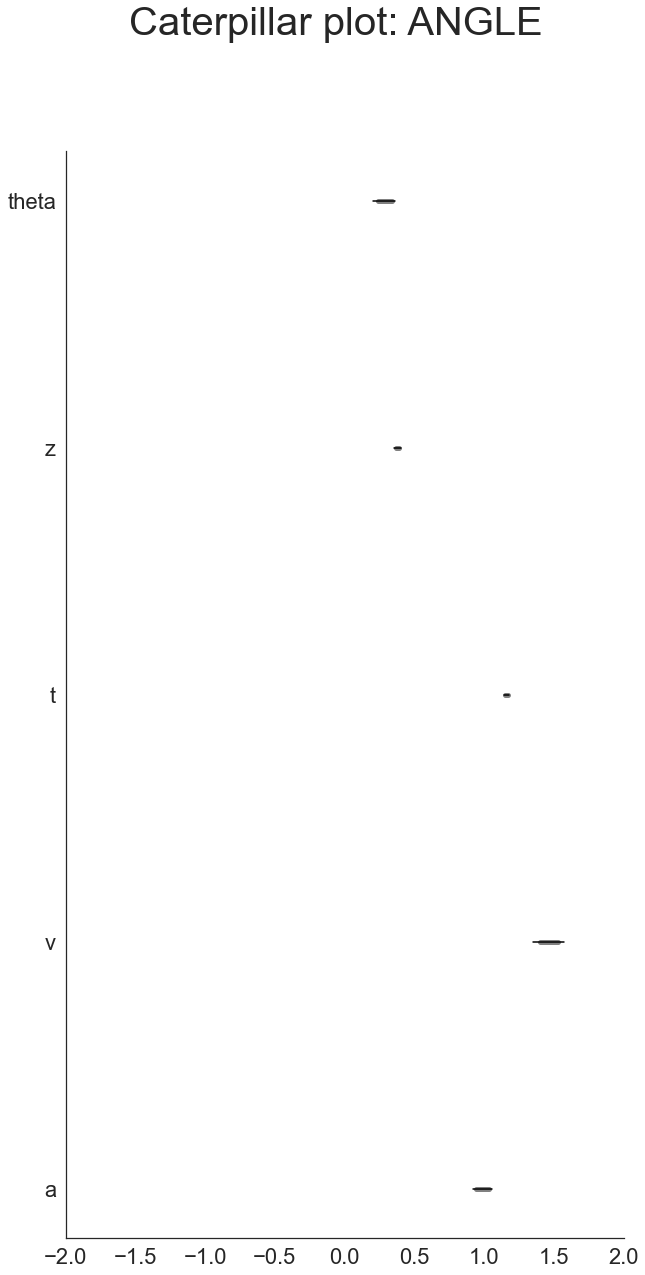

In [30]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model.get_traces(),
                 ground_truths = None, #weibull_params.values[0],
                 model = model,
                 datatype = 'stimcoding',
                 drop_sd = True)

### NOTE: 

The `model_plot()`, `posterior_predictive_plot()`, and `caterpillar_plot()` functions still need to properly incorporate *stimcoding* data. This will be updated as soon as possible.

# SECTION 7: MODEL RECOVERY

Lastly we are going to look at model recovery, because it is tempting now that we have three kinds of models at our hands ( **ddm / angle / weibull **). 

For the little model recovery study we conduct here, we generate data from the **weibull** model and fit the data once each to the  **weibull**, **angle** and **ddm** models.

We inspect the fits visually and then use the *DIC* (Deviance information criterion, lower is better :)), to check if we can recover the **true** model. 

In [38]:
# Let's generate data from one of our three models
params = make_parameter_sets(model = 'weibull_cdf',
                                     n_parameter_sets = 1)

simulations = simulator(theta = params.values[0],
                        model = 'weibull_cdf', 
                        n_samples = 1000)

hddm_data_recov = hddm_preprocess(simulations)

In [40]:
# Now we fit for each model:
hddm_model_single_subject_weibull = hddm.HDDMnn(hddm_data_recov, 
                                                informative = False,
                                                model = 'weibull_cdf',
                                                p_outlier = 0.0,
                                                include = hddm_include_config['weibull_cdf'],
                                                is_group_model = False)

hddm_model_single_subject_angle = hddm.HDDMnn(hddm_data_recov, 
                                              model = 'angle',
                                              informative = False,
                                              p_outlier = 0.0,
                                              include = hddm_include_config['angle'],
                                              is_group_model = False)

hddm_model_single_subject_ddm = hddm.HDDMnn(hddm_data_recov, 
                                            informative = False, 
                                            model = 'ddm',
                                            p_outlier = 0.0,
                                            include = hddm_include_config['ddm'],
                                            is_group_model = False)

Recognized HDDMnn
RT
1.117863
4.558792
Response
[-1.  1.]
knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('alpha_bottom', alpha), ('beta_bottom', beta)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('z', z), ('p_outlier', 0.0), ('w_outlier', 0.1), ('alpha', alpha), ('beta', beta)])
0.0
Recognized HDDMnn
RT
1.117863
4.558792
Response
[-1.  1.]
knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z), ('theta_bottom', theta)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('z', z), ('p_outlier', 0.0), ('w_outlier', 0.1), ('theta', theta)])
0.0
Recognized HDDMnn
RT
1.117863
4.558792
Response
[-1.  1.]
odict_keys(['a_bottom', 'v_bottom', 't_bottom', 'z_trans', 'z_bottom'])
knodes
OrderedDict([('a_bottom', a), ('v_bottom', v), ('t_bottom', t), ('z_trans', z_trans), ('z_bottom', z)])
wfpt parents: 
OrderedDict([('a', a), ('v', v), ('t', t), ('z', z), ('

In [41]:
nmcmc = 500
hddm_model_single_subject_weibull.sample(nmcmc, 
                                         burn = 200)

hddm_model_single_subject_angle.sample(nmcmc, 
                                       burn = 200)

hddm_model_single_subject_ddm.sample(nmcmc, 
                                     burn = 200)

 [-----------------100%-----------------] 500 of 500 complete in 15.5 sec

### CHECKING THE MODEL FITS VISUALLY

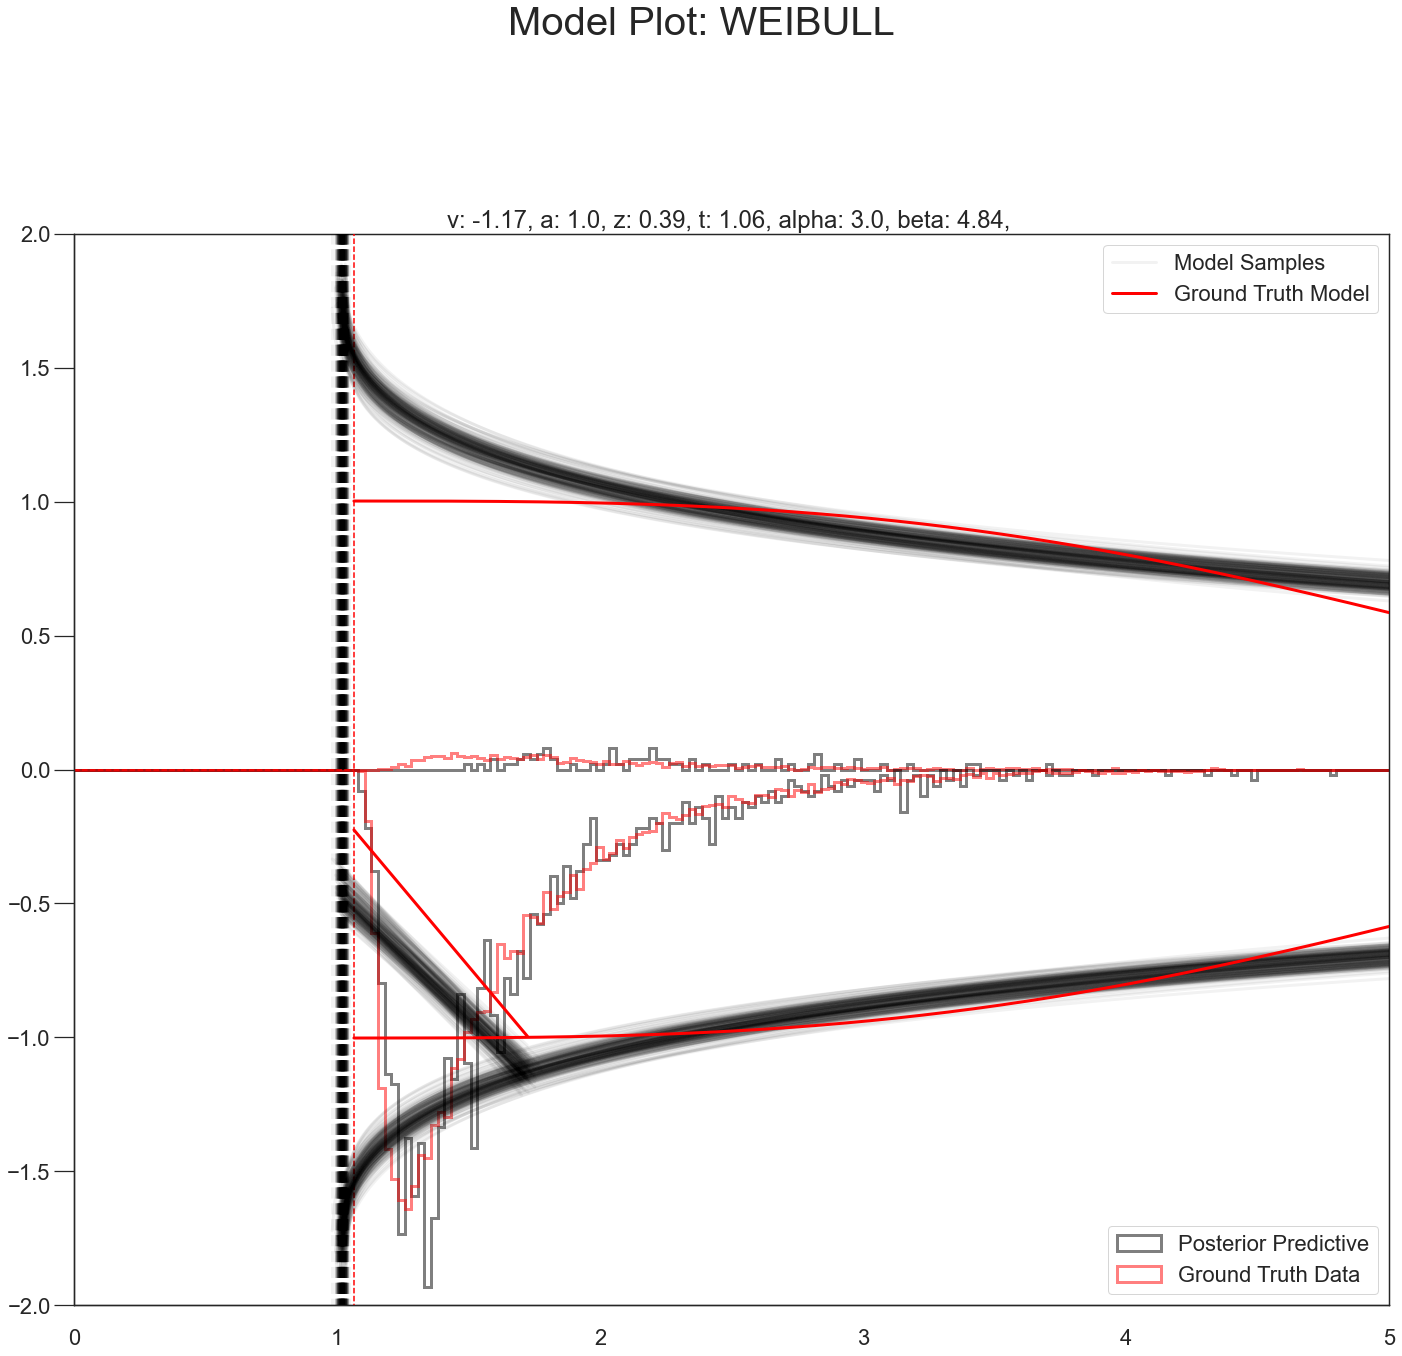

In [42]:
# Posterior Predictive: Do the 'Posterior Models' also make sense?
model_plot(ground_truths_parameters = params.values[0],
           posterior_samples = hddm_model_single_subject_weibull.get_traces(),
           model_gt = 'weibull_cdf',
           model_fitted = 'weibull_cdf',
           n_post_params = 200,
           cols = 1,
           n_plots = 1,
           max_t = 5,
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

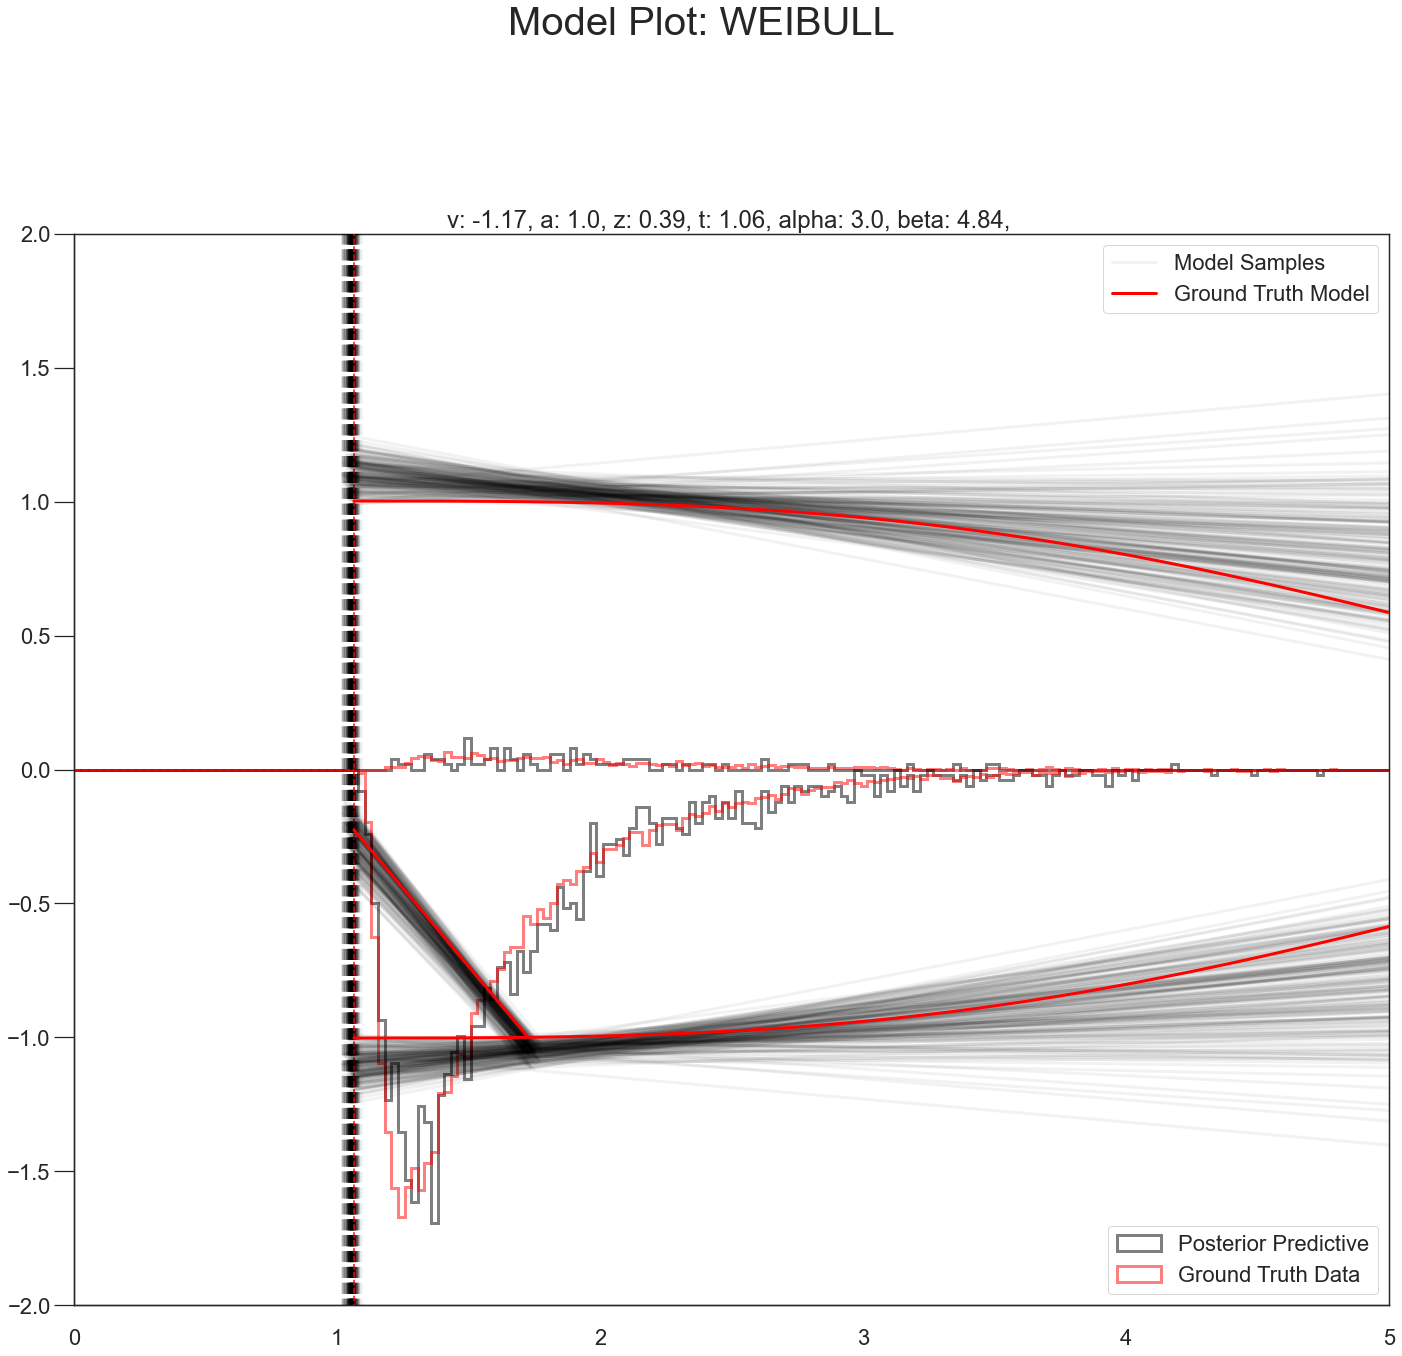

In [43]:
# Posterior Predictive: Do the 'Posterior Models' also make sense?
model_plot(ground_truths_parameters = params.values[0],
           posterior_samples = hddm_model_single_subject_angle.get_traces(),
           model_gt = 'weibull_cdf',
           model_fitted = 'angle',
           n_post_params = 200,
           cols = 1,
           n_plots = 1,
           max_t = 5,
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

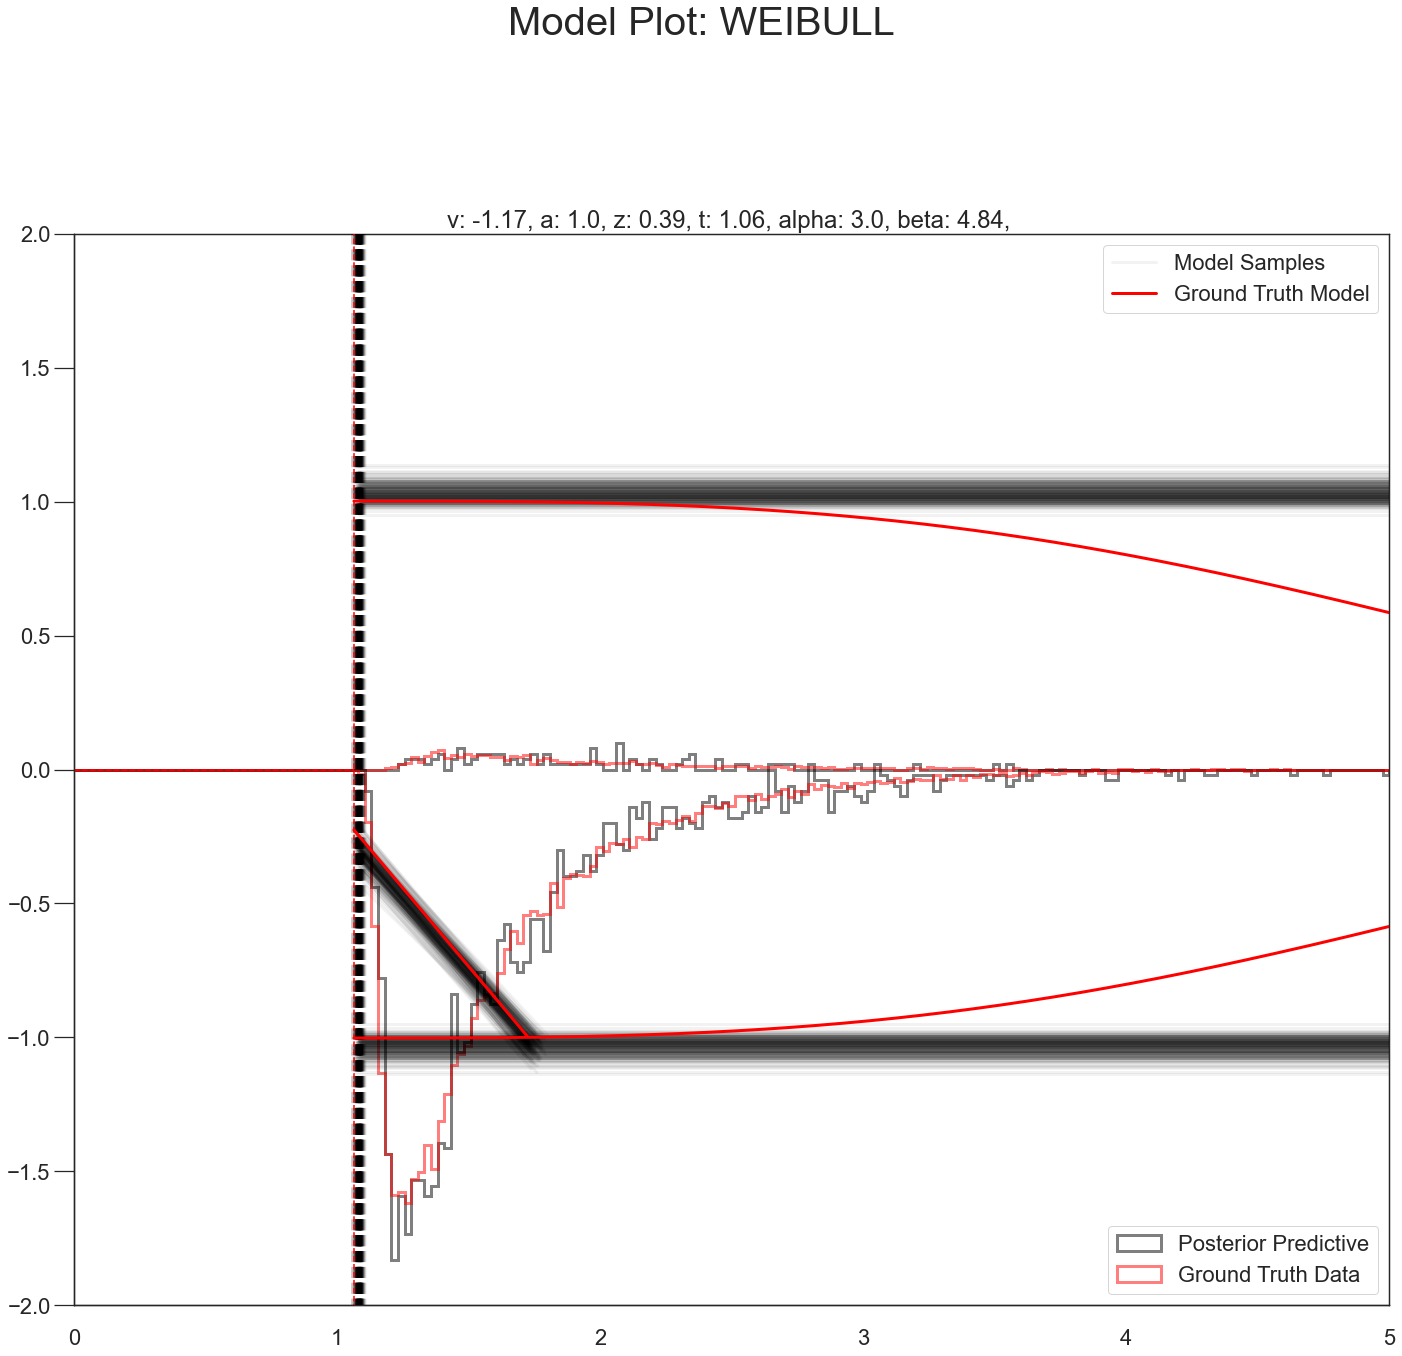

In [44]:
# Posterior Predictive: Do the 'Posterior Models' also make sense?
model_plot(ground_truths_parameters = params.values[0],
           posterior_samples = hddm_model_single_subject_ddm.get_traces(),
           model_gt = 'weibull_cdf',
           model_fitted = 'ddm',
           n_post_params = 200,
           cols = 1,
           n_plots = 1,
           max_t = 5,
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

### Let's compare the DIC's 

In [45]:
hddm_model_single_subject_weibull.dic

1137.8225862630206

In [46]:
hddm_model_single_subject_angle.dic

1162.2813142903647

In [47]:
hddm_model_single_subject_ddm.dic

1164.1251888020834

**Fingers crossed** (this was a random run after all), the DIC usually gives us a result that conforms with the intuition we get from looking at the model plots. 

Hopefully this tutorial proves as a useful starting point for your application.